# What are trees and how to grow them?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

# Drzewa i lasy losowe!

Oryginalny [artykuł](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)! Polecam do przeczytania/przejrzenia. Nawet dzisiaj jest tam wciąż sporo wartościowych uwag.

# Wczytajmy dane
Ponownie zestaw danych titanic, z labów 3

In [2]:
titanic = pd.read_csv("../lab3/titanic.csv")

### Data processing

In [3]:
titanic = titanic.drop('Cabin', axis = 1)
titanic.loc[titanic['Age'].isna(),'Age'] = titanic['Age'].mean()
titanic.loc[titanic['Fare'].isna(),'Fare'] = titanic['Fare'].median()
titanic.loc[titanic['Embarked'].isna(),'Embarked'] = titanic['Embarked'].mode().iloc[0]
titanic['name_length'] = titanic['Name'].str.len()
titanic = titanic.drop(["PassengerId","Name","Ticket"], axis=1)
for col in ['Fare','Age','name_length']:
    transf = titanic[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    titanic[col] = scaler.transform(transf)
titanic['Sex'] = (titanic['Sex'] == 'female')*1
encoded = pd.get_dummies(titanic[["Pclass","Embarked"]].astype(str))
encoded = encoded.drop(["Pclass_1","Embarked_C"], axis = 1)
titanic = titanic.drop(["Pclass","Embarked"], axis=1)
titanic = pd.concat([titanic, encoded], axis = 1)

przypomnijmy sobie jak wyglądają

In [4]:
titanic.head()

,Survived,Sex,Age,SibSp,Parch,Fare,name_length,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,0,-0.611972,1,0,-0.503291,-0.434672,0,1,0,1
1,1,1,0.630431,1,0,0.734744,2.511806,0,0,0,0
2,1,1,-0.301371,0,0,-0.490240,-0.539904,0,1,0,1
3,1,1,0.397481,1,0,0.383183,1.775186,0,0,0,1
4,0,0,0.397481,0,0,-0.487824,-0.329441,0,1,0,1


## Train_test_split

In [58]:
y = titanic['Survived']
X = titanic.drop("Survived", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, train_size=0.7)

### Zobaczmy kilka popularnych klasyfikatorów

In [59]:
lr = LogisticRegression(solver="newton-cg")
svm = SVC()
rf = RandomForestClassifier()

### Ich wyniki
To dalej niestety accuracy

In [60]:
lr.fit(X_train, y_train).score(X_test, y_test)

0.8396946564885496

In [61]:
svm.fit(X_train, y_train).score(X_test, y_test)

0.8473282442748091

In [62]:
rf.fit(X_train, y_train).score(X_test, y_test)

0.8575063613231552

### I czego te modele się 'uczą'?

In [10]:
lr.coef_

array([[ 3.0285272 , -0.41014193, -0.24267754, -0.03033846,  0.21193829,
         0.38914288, -0.47085151, -1.26344589, -0.08922679, -0.40777014]])

In [11]:
svm.coef_

array([[ 2.00001277e+00,  4.32160836e-05, -3.18363637e-05,
        -3.35768477e-05, -1.36975649e-05,  6.22579470e-05,
         1.03675691e-04,  4.68197119e-05, -2.15071466e-04,
        -2.02234317e-06]])

### A w przypadku random foresta?

In [12]:
rf.estimators_[:5]

[DecisionTreeClassifier(max_features='auto', random_state=1912410733),
 DecisionTreeClassifier(max_features='auto', random_state=992108951),
 DecisionTreeClassifier(max_features='auto', random_state=1618092849),
 DecisionTreeClassifier(max_features='auto', random_state=1512536781),
 DecisionTreeClassifier(max_features='auto', random_state=1973984617)]

To jest nasz las

In [13]:
len(rf.estimators_)

100

## Drzewa decyzyjne

In [14]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

### Jak wyglądają?
Przykład ogromnego (za bardzo dopasowanego drzewa)

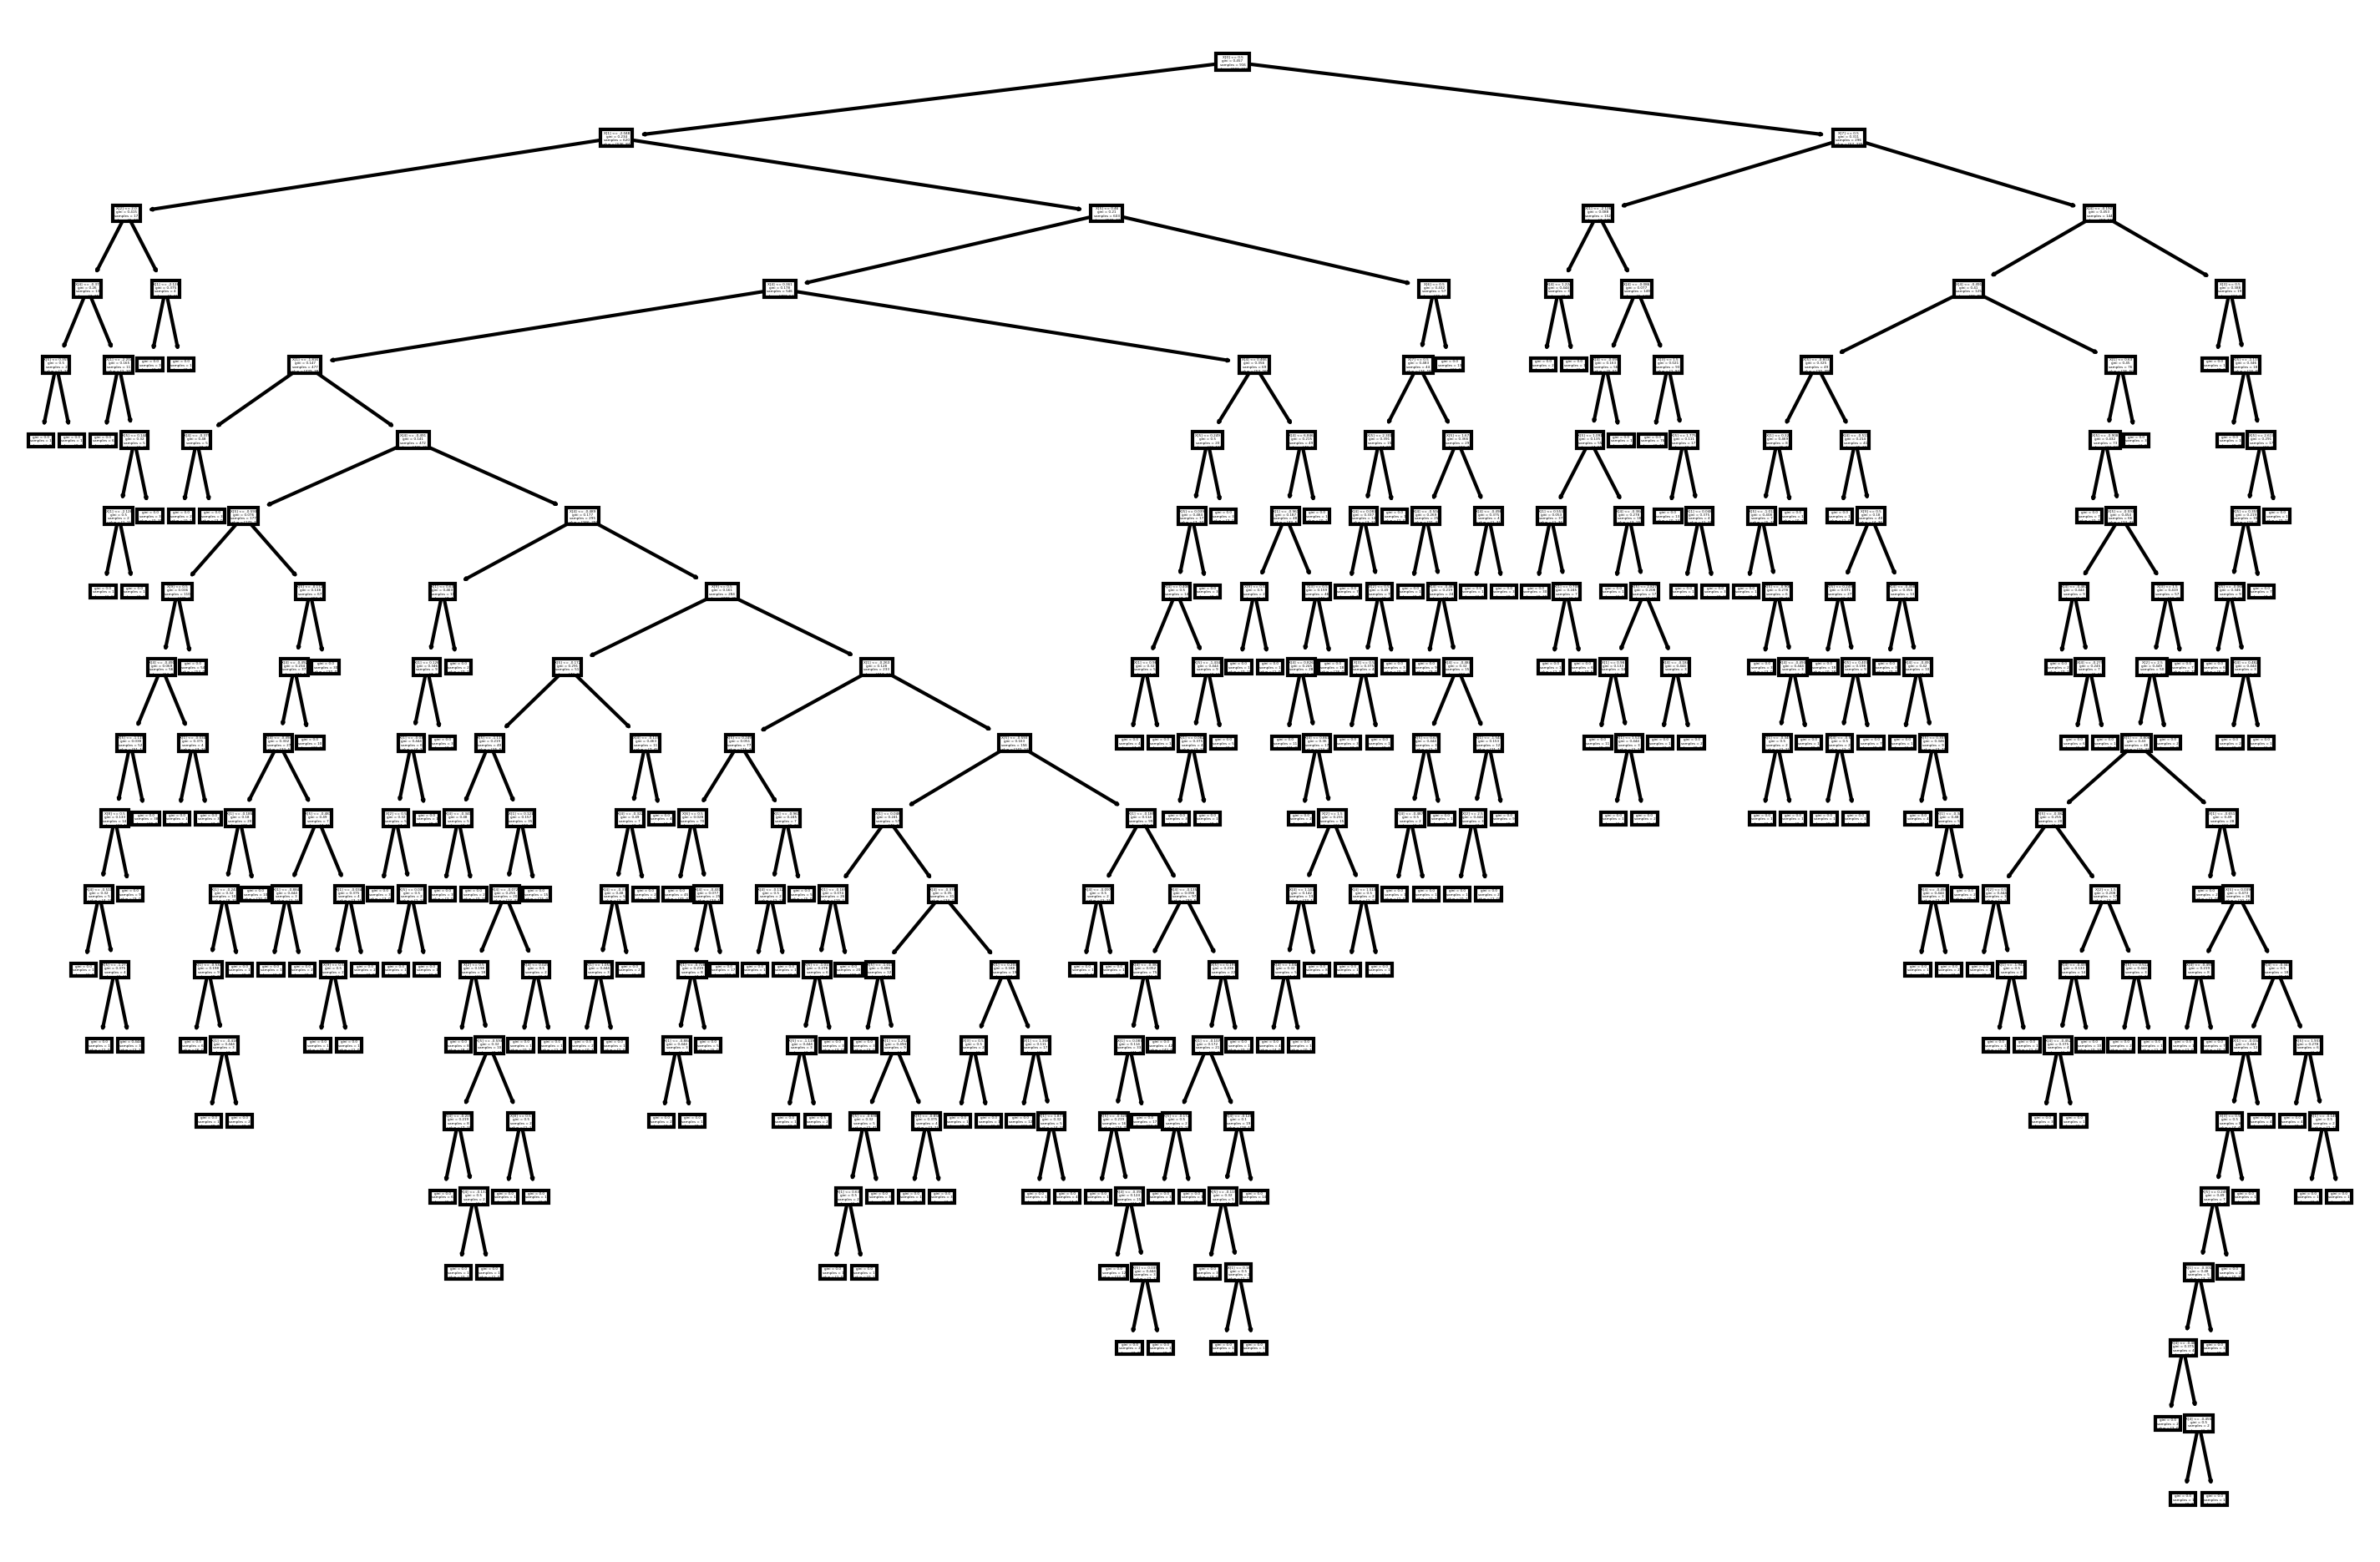

In [15]:
plt.figure(dpi=300)
plot_tree(tree)
plt.show()

In [16]:
tree.score(X_train, y_train)

0.9978165938864629

In [17]:
tree.score(X_test, y_test)

0.8015267175572519

## Dlaczego dopasowuje się tak dobrze do danych uczących? 

### Proces tworzenia drzewa decyzyjnego

Zakładamy, że dana kolumna informuje nas o przynależeniu do konkretnej klasy celu i mierzymy jak dobrze nasze założenie dzieli klasę celu

In [18]:
column_values = X.Sex.values

In [23]:
split_left = np.argwhere(column_values == 0)
split_right = np.argwhere(column_values != 0)

l_y = y.values[split_left]
r_y = y.values[split_right]

In [24]:
np.unique(r_y, return_counts = True)

(array([0, 1], dtype=int64), array([ 81, 385], dtype=int64))

Jak określamy dobry podział zmiennej celu? Miarą Gini $$gini(x)\in[0,1]$$ gdzie najlepszą oceną jest wartość 0 mówiąca, że mamy dane tylko z jednej klasy

In [25]:
def calc_gini(y):
    if np.unique(y).shape[0] < 2:
        return 0
    return 1 - (y[y==1].shape[0]/y.shape[0])**2 - (y[y==0].shape[0]/y.shape[0])**2

ocena prawego podziału

In [26]:
calc_gini(r_y)

0.2872128792204682

In [27]:
np.unique(l_y, return_counts = True)

(array([0, 1], dtype=int64), array([734, 109], dtype=int64))

ocena lewego podziału

In [29]:
calc_gini(l_y)

0.22516319589558287

średnia ważona z obu podziałów uwzględnia liczność obserwacji

In [30]:
(calc_gini(r_y)*r_y.shape[0]+calc_gini(l_y)*l_y.shape[0])/y.shape[0]

0.24725269354982013

In [31]:
def calc_binary_split(X, column_name, y):
    column = X[column_name].values
    split_left = X.loc[X[column_name]==0].index
    l_X = X.loc[split_left]
    l_y = y.loc[split_left]
    r_X = X.loc[~X.index.isin(split_left)]
    r_y = y.loc[~y.index.isin(split_left)]
    gini_score = (calc_gini(r_y.values)*r_y.shape[0]+calc_gini(l_y.values)*l_y.shape[0])/y.shape[0]
    return l_X, l_y, r_X, r_y, gini_score

def calc_vector_split(vector, y):
    assert(vector.shape == y.shape)
    split_left = np.argwhere(vector == 0)
    split_right = np.argwhere(vector != 0)
    l_y = y[split_left]
    r_y = y[split_right]
    gini_score = (calc_gini(r_y)*r_y.shape[0]+calc_gini(l_y)*l_y.shape[0])/y.shape[0]
    return gini_score

def calc_numeric_split(X, column_name, y):
    column = X[column_name].values
    
    # sort values
    order = np.argsort(column)
    column = column[order]
    y = y[order]    
    
    # create the means
    means = (column[1:] + column[:-1])/2
    
    # find best mean
    min_gini = 1 # gini is from [0,1]
    best_mean = None
    for mean_split in np.unique(means)[1:]:
        binary_col = column<=mean_split
        gini_score = calc_vector_split(binary_col, y.values)
        if gini_score<min_gini:
            min_gini = gini_score
            best_mean = mean_split
            
    split_left = X.loc[X[column_name]<=best_mean].index
    l_X = X.loc[split_left]
    l_y = y.loc[split_left]
    r_X = X.loc[~X.index.isin(split_left)]
    r_y = y.loc[~y.index.isin(split_left)]
    gini_score = (calc_gini(r_y.values)*r_y.shape[0]+calc_gini(l_y.values)*l_y.shape[0])/y.shape[0]
    return l_X, l_y, r_X, r_y, gini_score


### Sprawdźmy wszystkie kolumny binarne

In [32]:
binary_cols = ["Sex","Pclass_2","Pclass_3","Embarked_Q","Embarked_S"]

for column in binary_cols:
    _, _, _, _, gini_score = calc_binary_split(X, column, y)
    print(f"Column {column}, gini: {gini_score:.3f}")

Column Sex, gini: 0.247
Column Pclass_2, gini: 0.469
Column Pclass_3, gini: 0.442
Column Embarked_Q, gini: 0.469
Column Embarked_S, gini: 0.462


### Najlepszym korzeniem jest kolumna `Sex`

In [33]:
l_X, l_y, r_X, r_y, gini_score = calc_binary_split(X, "Sex", y)

In [34]:
binary_cols = ["Pclass_2","Pclass_3","Embarked_Q","Embarked_S"]

for column in binary_cols:
    _, _, _, _, gini_score = calc_binary_split(r_X, column, r_y)
    print(f"Column {column}, gini: {gini_score:.3f}")

Column Pclass_2, gini: 0.279
Column Pclass_3, gini: 0.243
Column Embarked_Q, gini: 0.287
Column Embarked_S, gini: 0.281


Natomiast dalej najlepszy podział oferuje kolumna `Pclass_3`

### A jak w przypadku numerycznych?

In [35]:
column = X["Fare"].values
# sort values
order = np.argsort(column)
column = column[order]
y = y[order]
means = (column[1:] + column[:-1])/2

In [36]:
for mean_split in np.unique(means)[1:]:
    binary_col = column<mean_split
    gini_score = calc_vector_split(binary_col, y.values)
    print(f"{gini_score:.5f} for mean {mean_split:.4f}")

0.46726 for mean -0.6128
0.46704 for mean -0.5740
0.46683 for mean -0.5563
0.46661 for mean -0.5348
0.46639 for mean -0.5209
0.46639 for mean -0.5190
0.46572 for mean -0.5189
0.46550 for mean -0.5183
0.46550 for mean -0.5179
0.46483 for mean -0.5154
0.46483 for mean -0.5130
0.46438 for mean -0.5119
0.46415 for mean -0.5100
0.46415 for mean -0.5091
0.46474 for mean -0.5088
0.46474 for mean -0.5086
0.46526 for mean -0.5084
0.46526 for mean -0.5081
0.46571 for mean -0.5077
0.46550 for mean -0.5072
0.46550 for mean -0.5072
0.46357 for mean -0.5071
0.46357 for mean -0.5071
0.46313 for mean -0.5064
0.46313 for mean -0.5057
0.46224 for mean -0.5055
0.46295 for mean -0.5046
0.46295 for mean -0.5038
0.46188 for mean -0.5037
0.46188 for mean -0.5037
0.46158 for mean -0.5035
0.46158 for mean -0.5033
0.45856 for mean -0.5030
0.45915 for mean -0.5024
0.45893 for mean -0.5003
0.45893 for mean -0.4985
0.45907 for mean -0.4983
0.45886 for mean -0.4978
0.45886 for mean -0.4975
0.45793 for mean -0.4972


0.44392 for mean 0.4285
0.44493 for mean 0.4329
0.44493 for mean 0.4373
0.44497 for mean 0.4431
0.44497 for mean 0.4488
0.44603 for mean 0.4530
0.44603 for mean 0.4572
0.44698 for mean 0.4579
0.44698 for mean 0.4586
0.44793 for mean 0.4658
0.44793 for mean 0.4731
0.44796 for mean 0.4753
0.44796 for mean 0.4775
0.44889 for mean 0.4913
0.44889 for mean 0.5050
0.44984 for mean 0.5108
0.44984 for mean 0.5166
0.44988 for mean 0.5279
0.44988 for mean 0.5393
0.44991 for mean 0.5413
0.44991 for mean 0.5433
0.44904 for mean 0.5491
0.44904 for mean 0.5549
0.44907 for mean 0.5682
0.44907 for mean 0.5815
0.45000 for mean 0.5974
0.45000 for mean 0.6133
0.45051 for mean 0.6287
0.45051 for mean 0.6442
0.45054 for mean 0.6703
0.45054 for mean 0.6964
0.45145 for mean 0.6988
0.45145 for mean 0.7012
0.44828 for mean 0.7152
0.44828 for mean 0.7293
0.44828 for mean 0.7320
0.44828 for mean 0.7347
0.44828 for mean 0.7562
0.44828 for mean 0.7776
0.44455 for mean 0.7944
0.44455 for mean 0.8113
0.44340 for mean

In [37]:
numeric_cols = ["SibSp","Parch","Fare","name_length"]

for column in numeric_cols:
    l_X, l_y, r_X, r_y, gini_score = calc_numeric_split(X, column, y)
    print(f"Column {column}, gini: {gini_score:.2f}")

Column SibSp, gini: 0.46
Column Parch, gini: 0.46
Column Fare, gini: 0.44
Column name_length, gini: 0.41


## Liście
Liście powstają momencie gdy uzyskujemy gorszy wynik Gini wykonując split na dowolnej kolumnie. 

### Jak wykonać predykcje?

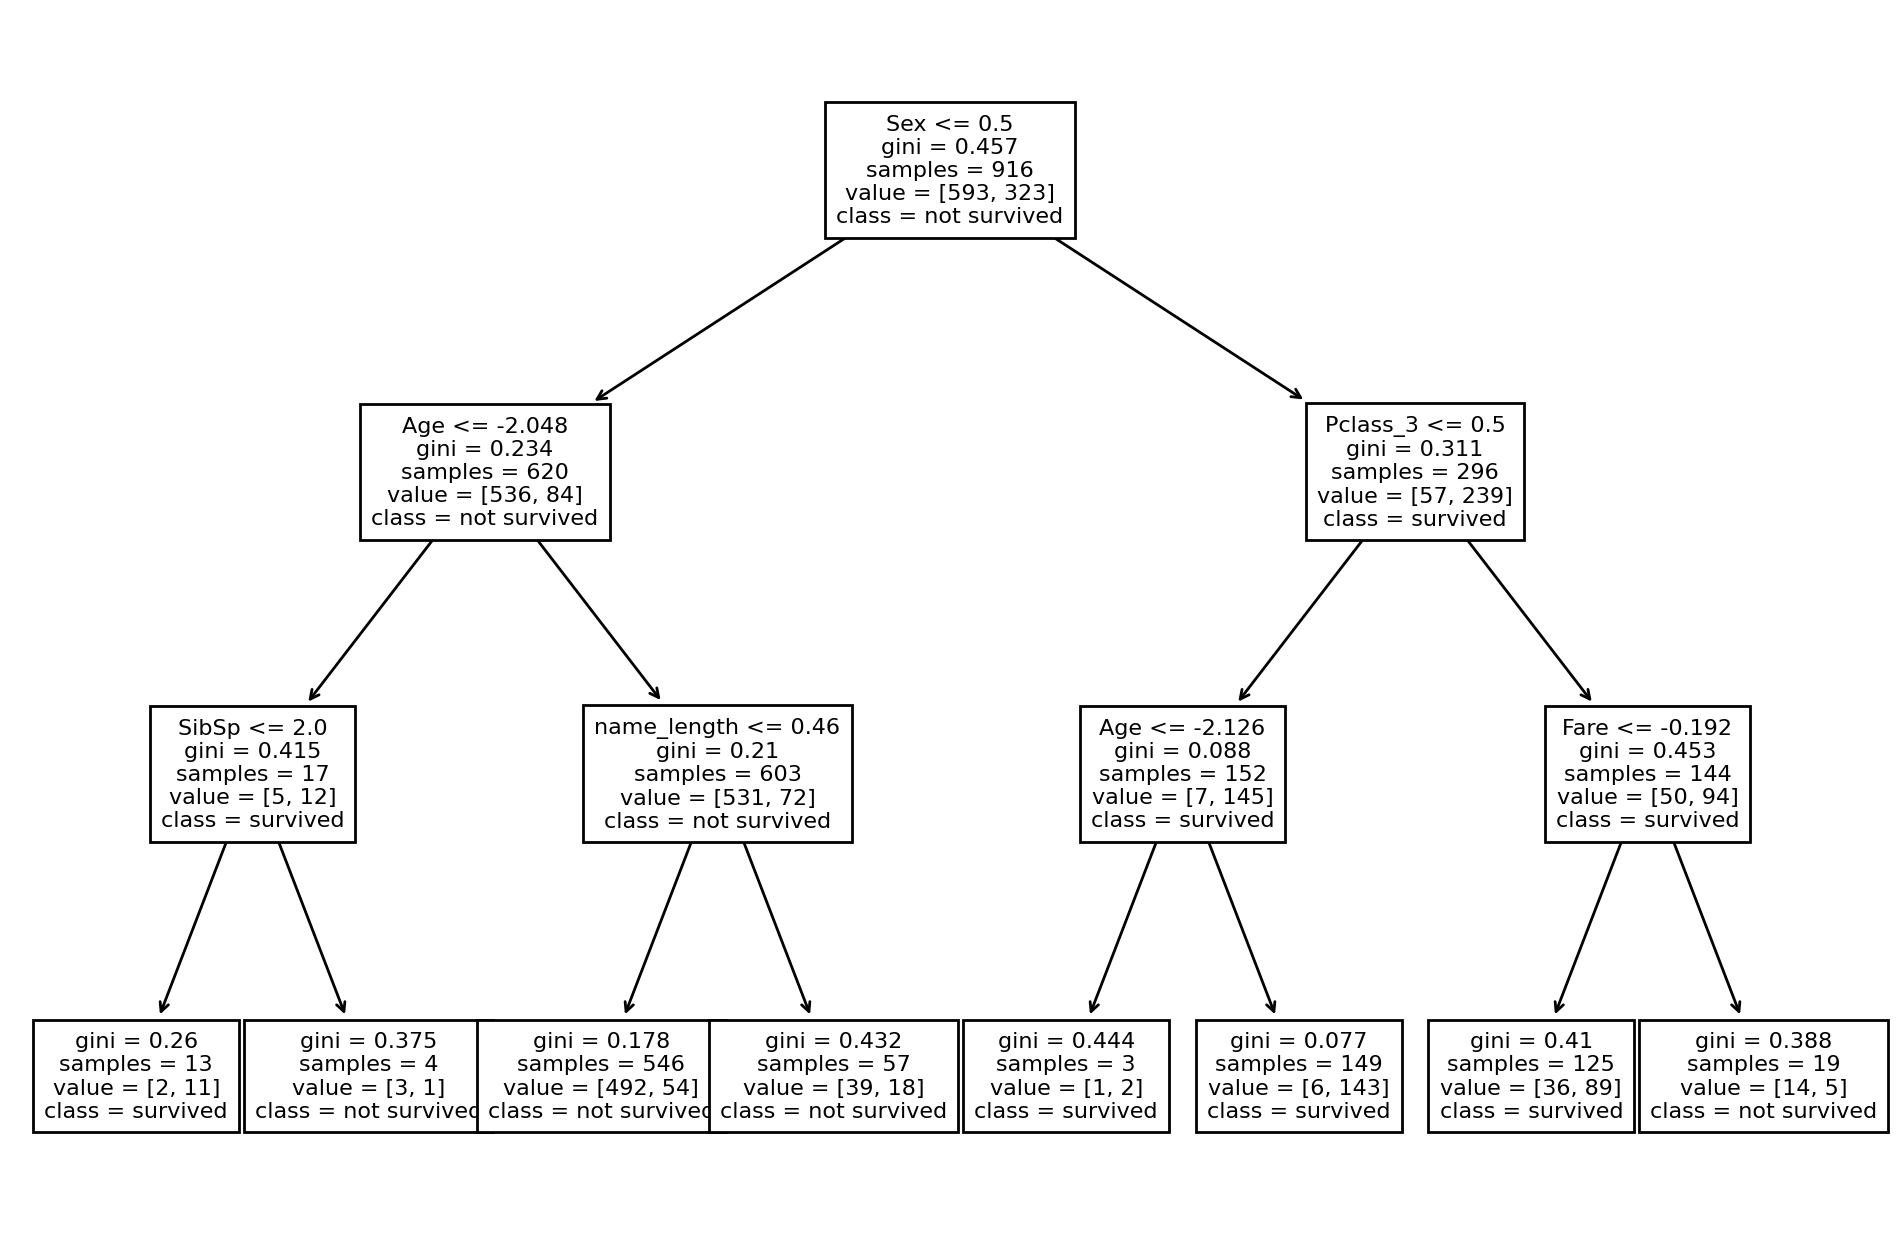

In [38]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train,y_train)
plt.figure(dpi=200)
plot_tree(tree, class_names=["not survived", "survived"], feature_names=X_train.columns, fontsize=8)
plt.show()

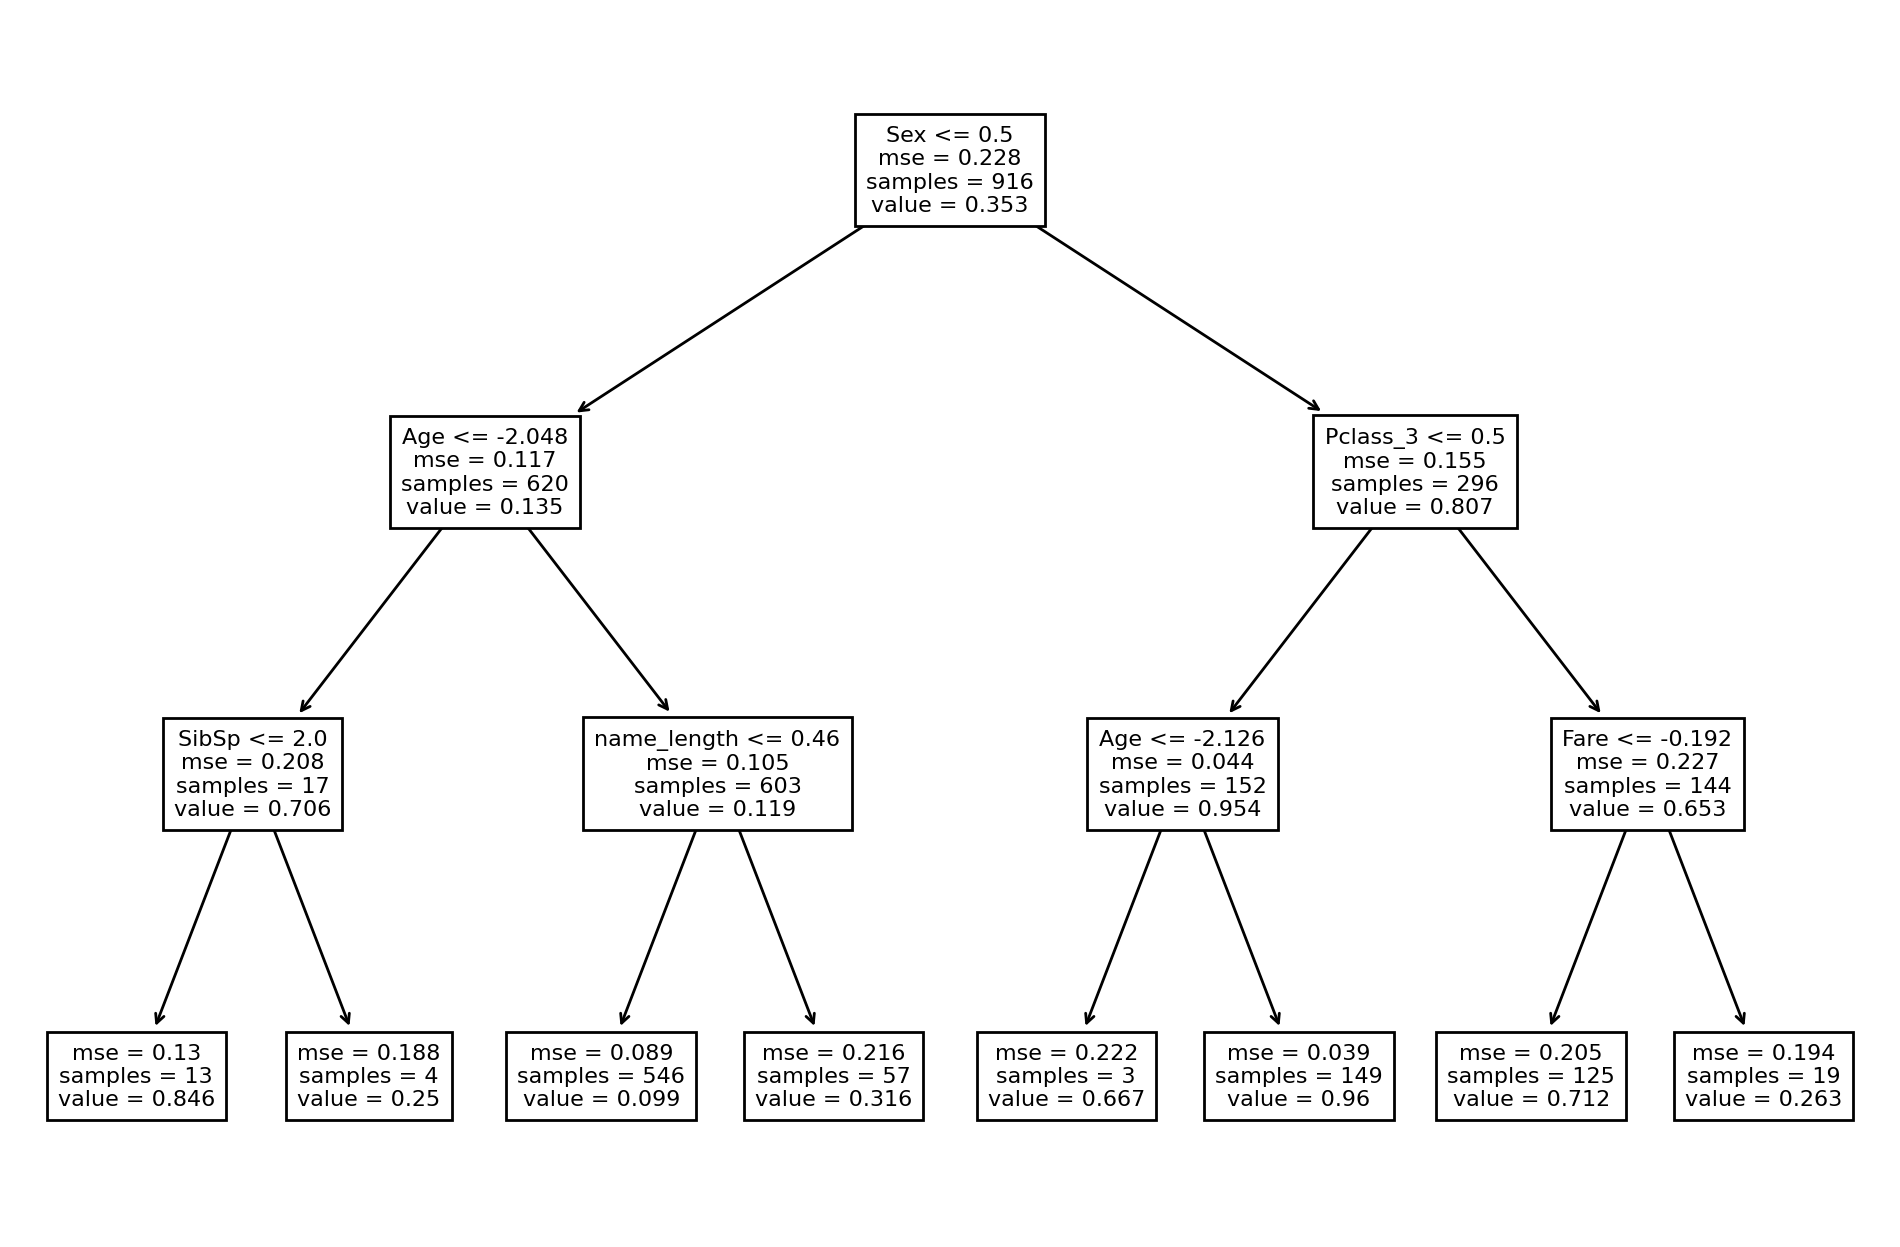

In [39]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train,y_train)
plt.figure(dpi=200)
plot_tree(tree, feature_names=X_train.columns, fontsize=8)
plt.show()

## Bagging
Czyli jak z wielu dobrych modeli zrobić jeszcze lepszy?

### Idea
 - ### 1. Stwórz n różnych modeli
 -  ### 2. Użyj każdego z nich by otrzymać n predykcji
 -  ### 3. Połącz n predykcji w jedną
 -  ### 4. Uzyskaj lepsze wyniki

## Bootstrap
Daje nam losowość powstających drzew, tak samo jak dodatkowy parametr `n_features`

In [40]:
df = X.iloc[:6].copy()
df

,Sex,Age,SibSp,Parch,Fare,name_length,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,-0.611972,1,0,-0.503291,-0.434672,0,1,0,1
1,1,0.630431,1,0,0.734744,2.511806,0,0,0,0
2,1,-0.301371,0,0,-0.490240,-0.539904,0,1,0,1
3,1,0.397481,1,0,0.383183,1.775186,0,0,0,1
4,0,0.397481,0,0,-0.487824,-0.329441,0,1,0,1
5,0,0.000000,0,0,-0.479930,-1.171292,0,1,1,0


In [41]:
n = 6 # rozmiar bootstrapowanego zbioru

In [42]:
df.iloc[np.random.randint(n, size=n)]

,Sex,Age,SibSp,Parch,Fare,name_length,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
3,1,0.397481,1,0,0.383183,1.775186,0,0,0,1
0,0,-0.611972,1,0,-0.503291,-0.434672,0,1,0,1
3,1,0.397481,1,0,0.383183,1.775186,0,0,0,1
3,1,0.397481,1,0,0.383183,1.775186,0,0,0,1
1,1,0.630431,1,0,0.734744,2.511806,0,0,0,0
3,1,0.397481,1,0,0.383183,1.775186,0,0,0,1


In [43]:
n = 500
for i in range(10):
    bootstrap_df = titanic.iloc[np.random.randint(n, size=n)]
    bs_y = bootstrap_df['Survived']
    bs_X = bootstrap_df.drop("Survived", axis = 1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)
    print(f"DecisionTreeClassifier_{i}score: {DecisionTreeClassifier().fit(bs_X,bs_y).score(X_test, y_test):.4f}")

DecisionTreeClassifier_0score: 0.8244
DecisionTreeClassifier_1score: 0.7990
DecisionTreeClassifier_2score: 0.7837
DecisionTreeClassifier_3score: 0.8321
DecisionTreeClassifier_4score: 0.8168
DecisionTreeClassifier_5score: 0.7888
DecisionTreeClassifier_6score: 0.8219
DecisionTreeClassifier_7score: 0.8041
DecisionTreeClassifier_8score: 0.8193
DecisionTreeClassifier_9score: 0.7939


## Bagging w `sklearn`

In [44]:
y = titanic['Survived']
X = titanic.drop("Survived", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [45]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100,
                  random_state=0)

Nasz prosty las (jeszcze nie w pełni las losowy) już uzyskuje dobre wyniki

In [46]:
clf.score(X_test, y_test)

0.8702290076335878

Znacząco lepsze od domyślnego drzewa decyzyjnego

In [47]:
DecisionTreeClassifier().fit(X_train, y_train).score(X_test, y_test)

0.8091603053435115

## A teraz przejdźmy do Random Foresta

In [48]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [49]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Cechy lasów losowych

### Dobra generalizacja przy dużej ilości drzew

In [50]:
cols = ["n_estimators","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

estimators = np.arange(3,300,5)
for trees_nr in tqdm(estimators):
    rf = RandomForestClassifier(n_estimators=trees_nr, n_jobs=-1).fit(X_train, y_train)
    train_score = roc_auc_score(y_train, rf.predict(X_train))
    test_score = roc_auc_score(y_test, rf.predict(X_test))
    history = history.append(dict(zip(cols, [trees_nr, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [trees_nr, test_score, "test"])), ignore_index=True)

  0%|          | 0/60 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n_estimators', ylabel='AUC'>

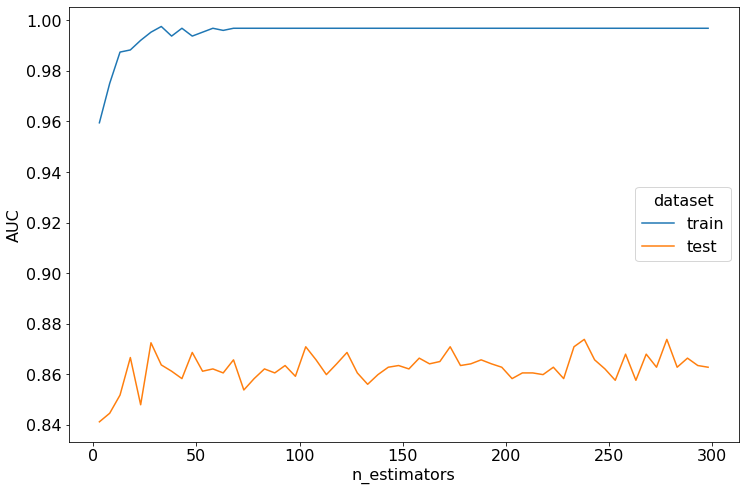

In [51]:
sns.lineplot(data=history, x = "n_estimators", y = "AUC", hue = "dataset")

### Dodanie ograniczenia na `max_depth`

In [52]:
cols = ["n_estimators","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

estimators = np.arange(3,300,5)
for trees_nr in tqdm(estimators):
    rf = RandomForestClassifier(n_estimators=trees_nr, max_depth=5, n_jobs=-1).fit(X_train, y_train)
    train_score = roc_auc_score(y_train, rf.predict(X_train))
    test_score = roc_auc_score(y_test, rf.predict(X_test))
    history = history.append(dict(zip(cols, [trees_nr, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [trees_nr, test_score, "test"])), ignore_index=True)

  0%|          | 0/60 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n_estimators', ylabel='AUC'>

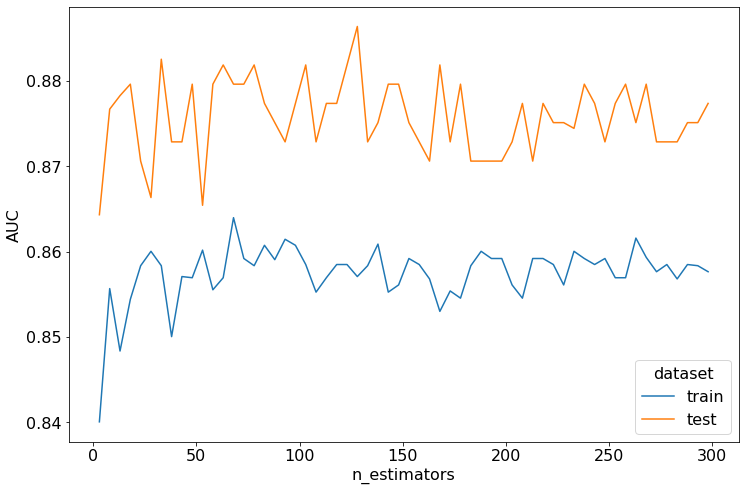

In [53]:
sns.lineplot(data=history, x = "n_estimators", y = "AUC", hue = "dataset")